In [1]:
import requests
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from bisect import bisect
from tqdm import tqdm
from matplotlib import rcParams
from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

# Ensure text is stored in a way Illustrator can edit
rcParams['pdf.fonttype'] = 42  
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=[
        "PatchClampSeries",
        "VoltageClampSeries",
        "CurrentClampSeries",
        "CurrentClampStimulusSeries",
    ],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

def has_related_publication(metadata):
    return "relatedResource" in metadata and any(x.get("relation") == "dcite:IsDescribedBy" for x in metadata["relatedResource"])

data = defaultdict(list)
for dandiset in tqdm(dandisets):
    dandiset = dandiset.for_version("draft")
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["modified"].append(dandiset.modified)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
        
    data["nauthors"].append(
        sum(x.get('schemaKey',[]) == "Person" for x in metadata["contributor"]) if "contributor" in metadata else 0
    )
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    data["numberOfSubjects"].append(metadata["assetsSummary"].get("numberOfSubjects", np.nan))
    data["numberOfFiles"].append(metadata["assetsSummary"].get("numberOfFiles", np.nan))        
    data["has_related_pub"].append(has_related_publication(metadata))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [02:33<00:00,  4.44it/s]


In [3]:
df = pd.DataFrame.from_dict(data)

In [4]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Danio rerio - Leopard danio": "Zebrafish",
    "Macaca mulatta - Rhesus monkey": "Rhesus monkey",
    "Danio rerio - Zebra fish": "Zebrafish",
    "Macaca nemestrina - Pig-tailed macaque": "Pig-tailed macaque",
    "Cricetulus griseus - Cricetulus aureus": "Chinese hamster",
    "Caenorhabditis elegans": "C. elegans",
    "Canis lupus familiaris - Dog": "Dog",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Bos taurus - Cattle": "Cattle",
    "Macaca nemestrina - Pigtail macaque": "Pig-tailed macaque",
    "Ooceraea biroi - Clonal raider ant": "Clonal raider ant",
    "Procambarus clarkii - Red swamp crayfish": "Red swamp crayfish",
    "Callithrix jacchus - Common marmoset": "Common marmoset",
    "Sus scrofa domesticus - Domestic pig": "Domestic pig",
    "Taeniopygia guttata - Zebra finch": "Zebra finch"
}

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

,identifier,created,modified,size,species,nauthors,ecephys,ophys,icephys,numberOfSubjects,numberOfFiles,has_related_pub
0,000003,2020-03-15 22:56:55.655000+00:00,2020-11-06 17:20:30.673000+00:00,2559248010229,House mouse,4,True,False,False,16.0,101,True
1,000004,2020-03-16 21:48:04.265000+00:00,2020-10-03 07:01:25.356000+00:00,6197474020,Human,13,True,False,False,59.0,87,True
2,000005,2020-03-16 22:52:44.757000+00:00,2020-04-09 20:59:35.377000+00:00,46436686324,House mouse,4,True,False,True,55.0,148,True
3,000006,2020-03-17 13:30:38.667000+00:00,2020-04-09 21:00:01.759000+00:00,139600500,House mouse,2,True,False,False,12.0,53,True
4,000007,2020-03-17 15:01:40.811000+00:00,2022-11-22 00:21:36.001459+00:00,199439472,House mouse,8,True,False,False,13.0,54,True
...,...,...,...,...,...,...,...,...,...,...,...,...
392,001470,2025-06-04 15:48:10.038425+00:00,2025-06-04 15:48:10.038449+00:00,3668403,House mouse,1,True,False,False,1.0,17,False
393,001473,2025-06-06 00:44:44.280653+00:00,2025-06-30 21:26:30.868047+00:00,55770644872,House mouse,1,False,False,False,3.0,5,False
394,001475,2025-06-16 02:55:15.780048+00:00,2025-06-16 02:55:15.780063+00:00,19338040,Rhesus monkey,1,True,False,False,1.0,1,False
395,001511,2025-06-19 19:45:52.295854+00:00,2025-06-19 19:45:52.295878+00:00,9352284,House mouse,1,True,False,False,1.0,1,False


In [5]:
df["species"].unique()

array(['House mouse', 'Human', nan, 'Rat', 'Rhesus monkey', 'Fruit fly',
       'Zebrafish', 'Pig-tailed macaque', 'Chinese hamster', 'Dog',
       'Clonal raider ant', 'C. elegans', 'Rabbit', 'Cattle',
       'Red swamp crayfish', 'Macaca nemestrina', 'Domestic pig',
       'Unidentified', 'Zebra finch', 'Common marmoset',
       'Meriones unguiculatus'], dtype=object)

In [6]:
df["species"].value_counts()

species
House mouse              174
Rat                       55
Human                     48
Rhesus monkey             36
Zebrafish                 21
Fruit fly                 11
Cattle                     9
C. elegans                 9
Macaca nemestrina          5
Chinese hamster            4
Unidentified               3
Clonal raider ant          2
Rabbit                     2
Pig-tailed macaque         2
Zebra finch                2
Dog                        1
Red swamp crayfish         1
Domestic pig               1
Common marmoset            1
Meriones unguiculatus      1
Name: count, dtype: int64

In [7]:
# read in u24 metrics which include event, consultation, and reuse statistics
df_u24_metrics = pd.read_csv('../data/nwb_statistics.csv', skiprows=1, index_col=0)

# clean up metrics
df_u24_metrics = (df_u24_metrics
    .assign(Consultations=lambda x: x['Tool consultations'] + x['User consultations'])  # combine user and tool consultations
    .drop(["User consultations", "Tool consultations", "Allen reuse publications"], axis=1)  # TODO - combine allen + data reuse when updated
    .cumsum())  # convert to cumulative sum
df_u24_metrics

,Event registrants,Community tools,Data reuse publications,Consultations
year,,,,
2017,30,0,0,0
2018,90,1,0,0
2019,176,2,0,0
2020,783,5,0,0
2021,1034,8,3,35
2022,1470,16,6,68
2023,1890,27,24,108
2024,2417,30,51,134
2025,2844,30,65,139


In [8]:
## combine u24 and dandi metrics and group by year
# n_dandisets
n_dandisets = (df['created'].dt.year
               .value_counts()
               .sort_index()
               .cumsum())

# n_bytes of data
n_terabytes = (df.groupby(df['modified'].dt.year)['size']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum()/10**12)  # cumsum by year and convert to TB

# n_sessions
n_sessions = (df.groupby(df['modified'].dt.year)['numberOfFiles']
               .sum()  # sum by year
               .sort_index()  # should be sorted but just in case
               .cumsum())  # cumsum by year

# n_species
unique_species = set()
species_count = dict()
for year, group in df.groupby(df['modified'].dt.year):
    unique_species.update(group['species'])
    species_count[year] = len(unique_species)
n_species = pd.DataFrame(data=species_count.values(), index=species_count.keys(), columns=['species'])

df_by_year = pd.concat([n_dandisets, n_terabytes, n_sessions, n_species, df_u24_metrics], axis=1)
df_by_year = (df_by_year
              .reset_index()
              .rename(columns={'count': 'datasets on DANDI',
                               'species':'species on DANDI',
                               'numberOfFiles':'sessions on DANDI',
                               'size': 'TBs on DANDI',
                               'index': 'year'})
             .sort_values('year')
             .query('year >= 2020')  # just for viz purposes
             .melt(id_vars=['year'], var_name='metric', value_name='value'))

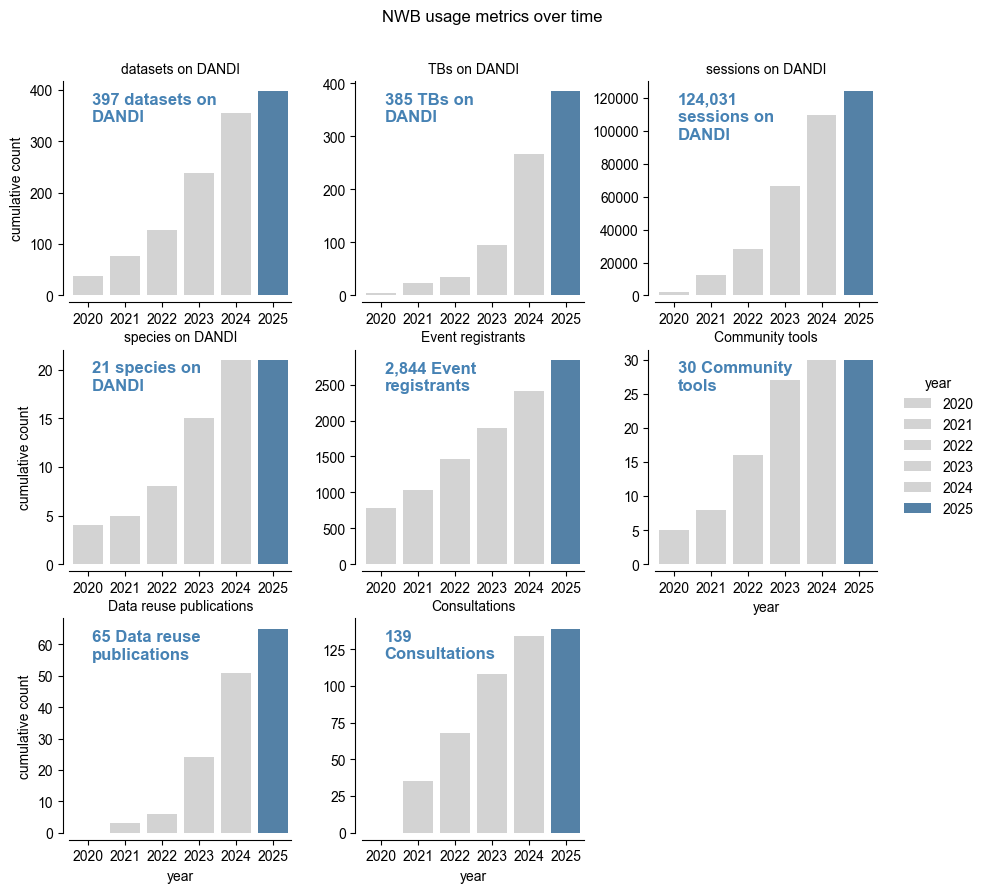

In [9]:
# plot the data by year
colors = ['lightgrey'] * (len(df_by_year['year'].unique()) - 1) + ['steelblue']
g = sns.catplot(data=df_by_year, x='year', y='value', kind='bar', hue='year',
                col='metric', col_wrap=3, sharey=False, sharex=True,
                height=3, palette=colors)

def add_2025_text(data, **kwargs):
    ax = plt.gca()
    value_2025 = data[data['year'] == 2025]['value'].iloc[0]
    text = f'{value_2025:,.0f} {ax.get_title()}'
    wrapped_text = '\n'.join(textwrap.wrap(text, width=15))
    ax.text(0.1, 0.95, wrapped_text, 
            transform=ax.transAxes, 
            fontsize=12, 
            color='steelblue',
            fontweight='bold',
            ha='left', va='top')

# update labels and text
(g.set_axis_labels("year", "cumulative count")
  .set_titles("{col_name}")
  .map_dataframe(add_2025_text)
  .tight_layout()
  .despine(offset=5)
  .fig.suptitle('NWB usage metrics over time')
  )
    
# adjust legend and spacing
plt.subplots_adjust(top=0.9)

# save figure
plt.savefig('key_usage_metrics_bar.pdf', format='pdf')

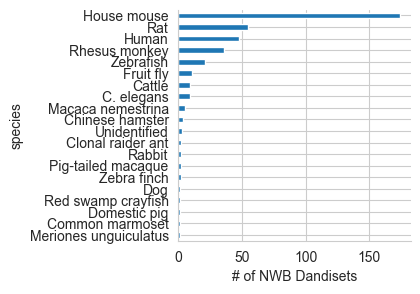

In [10]:
sns.set_style("whitegrid")
vals = df["species"]
# Only show short-hand label. E.g. ,replace "Procambarus clarkii - Red swamp crayfish" with "Red swamp crayfish"
for name in df["species"].value_counts().keys():
    if " - " in name:
        print(name)
        vals = vals.replace(name, name.split(" - ")[1]) 

ax = vals.value_counts().plot.barh(figsize=(3, 3))
ax.invert_yaxis()
ax.set_xlabel("# of NWB Dandisets")
ax.set_ylabel("species")
sns.despine()
ax.figure.savefig(
    "species.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


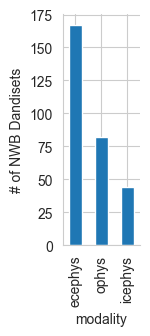

In [11]:
fig, ax = plt.subplots(figsize=(1, 3))

df[["ecephys", "ophys", "icephys"]].sum().plot.bar(ax=ax)
ax.set_xlabel("modality")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "modality.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

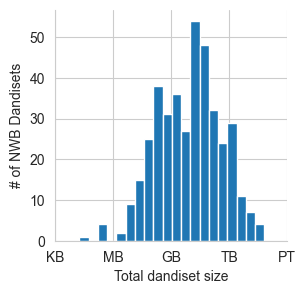

In [12]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

fig, ax = plt.subplots(figsize=(3, 3))
ax = logsize.plot.hist(bins=20, ax=ax)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.set_xlabel("Total dandiset size")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "size.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [13]:
df["size"].sum()/(1e12)  #TB

np.float64(385.042193746615)

In [14]:
df["size"].sum()

np.int64(385042193746615)

In [15]:
len(df)

397

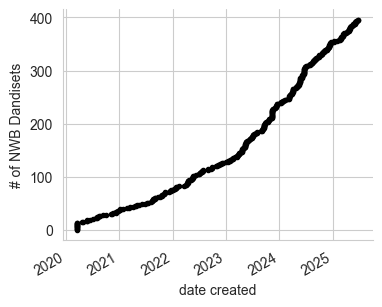

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight", dpi=300, transparent=True)

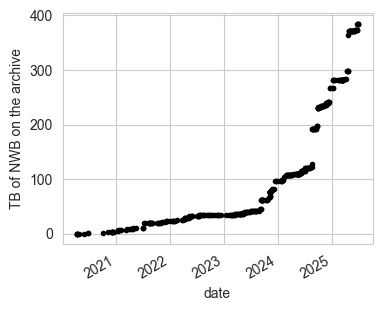

In [17]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['size'][order].cumsum()/10**12, '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("TB of NWB on the archive")

In [18]:
df.columns

Index(['identifier', 'created', 'modified', 'size', 'species', 'nauthors',
       'ecephys', 'ophys', 'icephys', 'numberOfSubjects', 'numberOfFiles',
       'has_related_pub'],
      dtype='object')

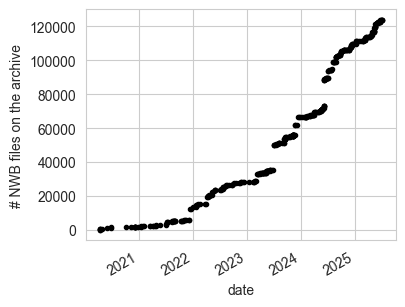

In [19]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['numberOfFiles'][order].cumsum(), '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("# NWB files on the archive")

[Text(0, 9, 'GB'), Text(0, 12, 'TB'), Text(0, 15, 'PB')]

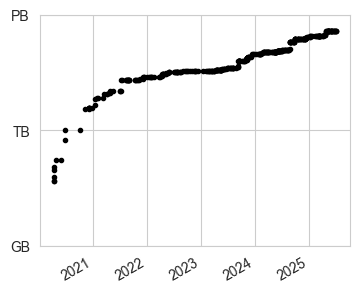

In [20]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([9,12,15])
ax.set_yticklabels(["GB", "TB", "PB"])

(12.0, 15.0)

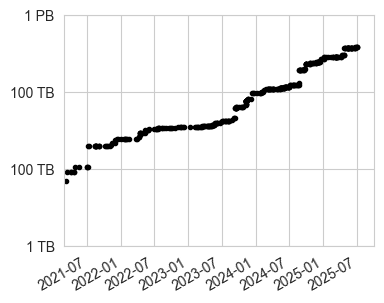

In [21]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([12, 13, 14, 15])
ax.set_yticklabels(["1 TB", "100 TB", "100 TB", "1 PB"])
ax.set_xlim(datetime(2021, 3, 1), None)
ax.set_ylim(12, 15)

In [22]:
date_idx = df['modified'][order].apply(lambda x: pd.to_datetime(x)).dt.date > datetime(2021,3,1).date()

In [23]:
seconds_in_a_day = 86400
days = (df['modified'][order]).apply(lambda x: (x.replace(tzinfo=None) - datetime(2021,3,1)).total_seconds()/seconds_in_a_day/365.25)

Text(0.5, 0, 'date')

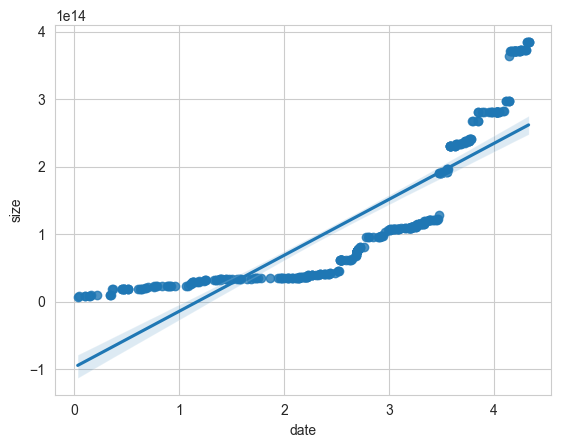

In [24]:
ax = sns.regplot(x=days[date_idx], y=df['size'][order].cumsum()[date_idx]);
ax.set_xlabel("date")
#ax.set_yticks([13, 14, 15])
#ax.set_yticklabels(["10 TB", "100 TB", "1 PB"])
#ax.set_yticks(12+np.log10(np.linspace(1,10,10)), minor=True)



Text(0, 0.5, 'total size (TB)')

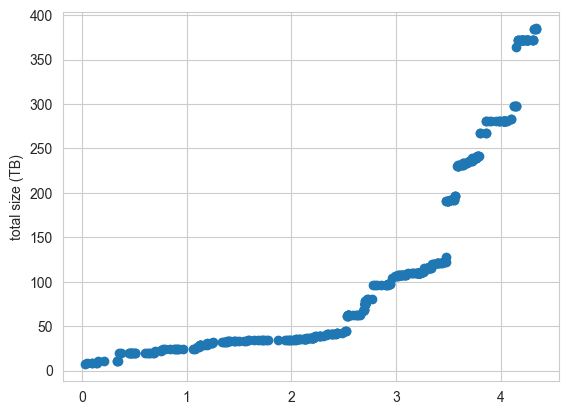

In [25]:
fig, ax = plt.subplots()
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.set_ylabel("total size (TB)")

(0.0, 3.0)

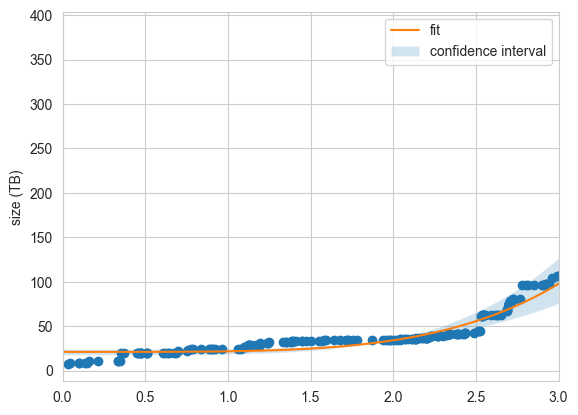

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, ax = plt.subplots()


# define the power-law function to fit
def power_law_func(x, a, b, c):
    return a * x**b - c

popt, pcov = curve_fit(power_law_func, days[date_idx], df['size'][order].cumsum()[date_idx]/10**12)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
x = np.linspace(0, 3, 100)
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.plot(x, power_law_func(x, *popt), label='fit')
ax.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
ax.set_ylabel("size (TB)")
ax.set_xlim(0,3)


In [27]:
12+np.log10(np.linspace(1,10,10))

array([12.        , 12.30103   , 12.47712125, 12.60205999, 12.69897   ,
       12.77815125, 12.84509804, 12.90308999, 12.95424251, 13.        ])

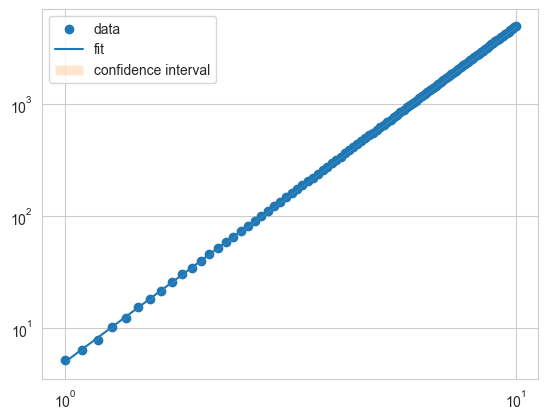

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# define the power-law function to fit
def power_law_func(x, a, b):
    return a * x**b

# generate some sample data
x = np.linspace(1, 10, 100)
y = 5 * x**(3) + np.random.normal(0, 0.2, size=len(x))

# fit the power-law function to the data
popt, pcov = curve_fit(power_law_func, x, y)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
plt.scatter(x, y, label='data')
plt.plot(x, power_law_func(x, *popt), label='fit')
plt.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [29]:
times = df['modified'][order]
days = (times - times.iloc[0]).apply(lambda x: x.total_seconds()/86400)

In [30]:
import scipy

x = days
y = df['size'][order].cumsum()

coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


/Users/smprince/Documents/code/nwb-project-analytics/nwb-project-analytics/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/smprince/Documents/code/nwb-project-analytics/nwb-project-analytics/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1024: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_88840/1395594452.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


In [31]:
coefs

array([1., 1.])

In [32]:
[1000**x for x in range(2,6)]
["MB", "GB", "TB", "PB"]

['MB', 'GB', 'TB', 'PB']

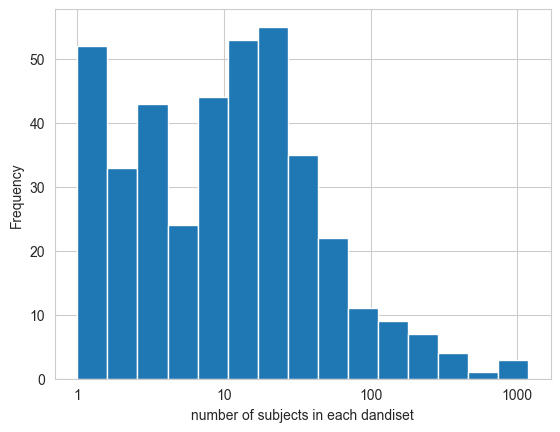

In [33]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlabel("number of subjects in each dandiset")
ax.figure.savefig("subjects.svg", bbox_inches="tight")

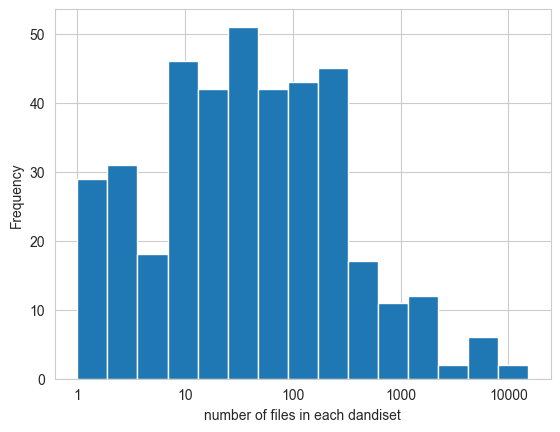

In [34]:
lognum = np.log10(df["numberOfFiles"])


ax = lognum.plot.hist(bins=15)
orders = np.arange(5)
ax.set_xticks(orders)
ax.set_xticklabels([10**x for x in orders])
ax.set_xlabel("number of files in each dandiset")
ax.figure.savefig("files.svg", bbox_inches="tight")

In [35]:
identifiers = df[
    (df["species"] == "House mouse") & 
    (df["numberOfSubjects"] > 40) & 
    (df["ecephys"] == True)
]["identifier"].values

In [36]:
# find only NWB files with male subjects

asset_list = []
for dandiset in dandisets:
    if dandiset.identifier not in identifiers:
        continue
    for asset in tqdm(list(dandiset.get_assets())):
        asset_metadata = asset.get_metadata()
        sex = asset_metadata.wasAttributedTo[0].sex
        if sex and sex.name == "Male":
            asset_list.append(asset)

  0%|                                                                                                               | 0/1576 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
len(asset_list)

In [ ]:
asset.get_metadata().wasAttributedTo[0].sex